# Multimodal
Combining images with facial action unit activations. 

In [1]:
name_of_this_notebook = 'late_fusion_cross_attention.ipynb'

BATCH_SIZE = 32
LR = 1e-3

experiment_name = f'batch-{BATCH_SIZE}-lr-{LR:.0e}-CROSS-ATTENTION'


In [2]:
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2024-10-31 18:13:12.631508: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 18:13:12.652612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 18:13:12.652632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 18:13:12.653378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 18:13:12.656964: I tensorflow/core/platform/cpu_feature_guar

## Prepare Data

In [3]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/emoji-hero-multimodal/')

### Prepare FAU Data

In [4]:
import pandas as pd

fau_data_path = dataset_path / 'facial_action_unit_activations'

fau_train_df = pd.read_csv(str(fau_data_path / 'training_set.csv')).sort_values(by='timestamp').reset_index(drop=True)
fau_val_df = pd.read_csv(str(fau_data_path / 'validation_set.csv')).sort_values(by='timestamp').reset_index(drop=True)
fau_test_df = pd.read_csv(str(fau_data_path / 'test_set.csv')).sort_values(by='timestamp').reset_index(drop=True)


def prepare_fau_data(df):
    X = df.iloc[:, 2:-1].values  # All columns except timestamp, participant_id, and label
    y = df.iloc[:, -1].values  # The last column is the label
    return X, y


fau_X_train, fau_y_train = prepare_fau_data(fau_train_df)
fau_X_val, fau_y_val = prepare_fau_data(fau_val_df)
fau_X_test, fau_y_test = prepare_fau_data(fau_test_df)

### Combine FAU with Image Data

Make sure that we have exactly two images (central and 45° side-view) for each FAU activations record. It is expected that there is not data for participant 7 (`<timestamp>-7-<camera-index>.jpg`). 

In [5]:
image_dataset_path = dataset_path / 'images'
image_train_set_path = image_dataset_path / 'training_set'
image_val_set_path = image_dataset_path / 'validation_set'
image_test_set_path = image_dataset_path / 'test_set'


def load_image_paths(image_set_path, fau_df):
    print(f'\nLoading images from {image_set_path}...')
    image_paths = []
    labels = []
    fau_records = []
    for label_dir in image_set_path.iterdir():
        for img_file in label_dir.iterdir():
            timestamp = int(img_file.name.split('-')[0])
            matching_fau = fau_df[fau_df['timestamp'] == timestamp]
            if not matching_fau.empty:
                image_paths.append(str(img_file))
                labels.append(int(label_dir.name))
                fau_records.append(matching_fau.iloc[0, 2:-1].values)
            else:
                print(f'Could not find FAU data for image {img_file.name}')
    print(f'Found {len(image_paths)} images with corresponding fau data in {image_set_path}\n')
    return fau_records, image_paths, labels


fau_train_records, image_train_paths, train_labels = load_image_paths(image_train_set_path, fau_train_df)
fau_val_records, image_val_paths, val_labels = load_image_paths(image_val_set_path, fau_val_df)
fau_test_records, image_test_paths, test_labels = load_image_paths(image_test_set_path, fau_test_df)


Loading images from /home/thor/Desktop/datasets/emoji-hero-multimodal/images/training_set...
Could not find FAU data for image 1700566596617-7-1.jpg
Could not find FAU data for image 1700566771764-7-1.jpg
Could not find FAU data for image 1700566743230-7-0.jpg
Could not find FAU data for image 1700566457312-7-1.jpg
Could not find FAU data for image 1700566609011-7-0.jpg
Could not find FAU data for image 1700566596617-7-0.jpg
Could not find FAU data for image 1700566743230-7-1.jpg
Could not find FAU data for image 1700566785956-7-1.jpg
Could not find FAU data for image 1700566785956-7-0.jpg
Could not find FAU data for image 1700566471449-7-1.jpg
Could not find FAU data for image 1700566457312-7-0.jpg
Could not find FAU data for image 1700566771764-7-0.jpg
Could not find FAU data for image 1700566609011-7-1.jpg
Could not find FAU data for image 1700566577455-7-1.jpg
Could not find FAU data for image 1700566471449-7-0.jpg
Could not find FAU data for image 1700566577455-7-0.jpg
Could not 

In [6]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)


def parse_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def load_combined_data(fau_records, image_paths, labels, batch_size, reshuffle_each_iteration):
    fau_dataset = tf.data.Dataset.from_tensor_slices(fau_records)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip(((image_dataset, fau_dataset), label_dataset))

    dataset = dataset.shuffle(buffer_size=len(fau_records), seed=SEED,
                              reshuffle_each_iteration=reshuffle_each_iteration)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


train_dataset = load_combined_data(fau_train_records, image_train_paths, train_labels, BATCH_SIZE, True)
val_dataset = load_combined_data(fau_val_records, image_val_paths, val_labels, BATCH_SIZE, False)
test_dataset = load_combined_data(fau_test_records, image_test_paths, test_labels, BATCH_SIZE, False)


2024-10-31 18:14:58.286541: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-31 18:14:58.286556: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: ubu-pcgh
2024-10-31 18:14:58.286559: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: ubu-pcgh
2024-10-31 18:14:58.286636: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2024-10-31 18:14:58.286643: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.183.1
2024-10-31 18:14:58.286645: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.183.1


### Prepare Class Frequencies for Loss Function 

In [7]:
id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}

class_frequencies = fau_train_df['Label'].value_counts()
print(f'--- Training Set Class Frequencies ---')
for class_id, frequency in class_frequencies.items():
    print(f'{class_id} - {id_to_emotion[class_id]:<9} : {frequency:>8}')

inverse_class_frequencies = 1 / class_frequencies
normalized_inverse_class_frequencies = inverse_class_frequencies / inverse_class_frequencies.sum()
class_weights = normalized_inverse_class_frequencies.to_dict()
print('\nClass Weights:\n', class_weights)

--- Training Set Class Frequencies ---
0 - Neutral   :      197
1 - Happy     :      191
3 - Surprise  :      172
2 - Sad       :      131
4 - Fear      :      105
5 - Disgust   :      102
6 - Anger     :       66

Class Weights:
 {0: 0.08716123123128974, 1: 0.08989928037991667, 3: 0.09983001484048884, 2: 0.13107452330201588, 4: 0.16353107192918173, 5: 0.16834080933886353, 6: 0.26016306897824365}


## Define Network Architecture

### Load Pretrained Models

In [8]:
from tensorflow.keras.models import load_model

models_base_path = Path(r'/home/thor/Desktop/repos/emoji-hero-baseline')

img_model_path = models_base_path / '2_image' / 'emojihero_transfer_imagenet_20240320-1526' / 'best_model_phase_5.keras'
fau_model_path = models_base_path / '1_face_expressions' / '20241031-1748-checkpoint-batch-32-lr-1e-03_val_8155_test_7169' / 'fau_model.keras'

img_model = load_model(str(img_model_path))
fau_model = load_model(str(fau_model_path))

In [9]:
img_test_dataset = test_dataset.map(lambda inputs, labels: (inputs[0], labels))
img_loss, img_accuracy = img_model.evaluate(img_test_dataset)
print(f'Image Model - Test Loss: {img_loss}, Test Accuracy: {img_accuracy}')

24/24 [==============================] - 6s 191ms/step - loss: 1.5114 - accuracy: 0.6984
Image Model - Test Loss: 1.5113863945007324, Test Accuracy: 0.6984127163887024


In [10]:
fau_test_dataset = test_dataset.map(lambda inputs, labels: (inputs[1], labels))
fau_loss, fau_accuracy = fau_model.evaluate(fau_test_dataset)
print(f'FAU Model - Test Loss: {fau_loss}, Test Accuracy: {fau_accuracy}')

24/24 [==============================] - 0s 1ms/step - loss: 0.9676 - accuracy: 0.7169
FAU Model - Test Loss: 0.9676137566566467, Test Accuracy: 0.7169312238693237


In [11]:
from keras.src.layers import Activation
from keras.src.initializers.initializers import GlorotUniform
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.layers import Layer


@register_keras_serializable()
class CrossAttention(Layer):
    def __init__(self, units):
        super(CrossAttention, self).__init__()
        self.units = units
        self.weight_layer_v1 = Dense(units, activation='softmax', kernel_initializer=GlorotUniform())
        self.weight_layer_v2 = Dense(units, activation='softmax', kernel_initializer=GlorotUniform())


    def call(self, inputs, training=False):
        v1, v2 = inputs

        weights_v1 = self.weight_layer_v1(v2)
        weights_v2 = self.weight_layer_v2(v1)

        weighted_v1 = weights_v1 * v1
        weighted_v2 = weights_v2 * v2

        combined_output = weighted_v1 + weighted_v2

        return Activation('softmax')(combined_output)


In [12]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

image_input = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
fau_input = Input(shape=(63,), name='fau_input')

image_output = img_model(image_input)
fau_output = fau_model(fau_input)

img_model.trainable = False
fau_model.trainable = False

combined_features = CrossAttention(7)([image_output, fau_output])

combined_model = Model(inputs=[image_input, fau_input], outputs=combined_features)
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 fau_input (InputLayer)      [(None, 63)]                 0         []                            
                                                                                                  
 EfficientNet (Functional)   (None, 7)                    4058538   ['image_input[0][0]']         
                                                                                                  
 model (Functional)          (None, 7)                    16903     ['fau_input[0][0]']           
                                                                                              

## Train the Network

In [13]:
import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = Path(f'{timestamp}-checkpoint-{experiment_name}')
checkpoint_loss = ModelCheckpoint(filepath=f'{checkpoint_dir / "best_model_by_loss"}.keras',
                                  save_weights_only=False,
                                  monitor='val_loss',
                                  mode='min',
                                  save_best_only=True)
checkpoint_acc = ModelCheckpoint(filepath=f'{checkpoint_dir / "best_model"}.keras',
                                 save_weights_only=False,
                                 monitor='val_accuracy',
                                 mode='max',
                                 save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=5, min_lr=1e-6)

callbacks = [checkpoint_loss, checkpoint_acc, early_stopping_callback, reduce_lr_callback]

optimizer = Adam(learning_rate=LR)

combined_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = combined_model.fit(train_dataset,
                             validation_data=val_dataset,
                             class_weight=class_weights,
                             callbacks=callbacks,
                             epochs=400)

Epoch 1/400
61/61 [==============================] - 22s 311ms/step - loss: 0.2151 - accuracy: 0.9855 - val_loss: 1.7724 - val_accuracy: 0.7974 - lr: 0.0010
Epoch 2/400
61/61 [==============================] - 18s 294ms/step - loss: 0.2128 - accuracy: 0.9824 - val_loss: 1.7582 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 3/400
61/61 [==============================] - 18s 298ms/step - loss: 0.2102 - accuracy: 0.9870 - val_loss: 1.7428 - val_accuracy: 0.7961 - lr: 0.0010
Epoch 4/400
61/61 [==============================] - 18s 295ms/step - loss: 0.2076 - accuracy: 0.9891 - val_loss: 1.7263 - val_accuracy: 0.7961 - lr: 0.0010
Epoch 5/400
61/61 [==============================] - 18s 294ms/step - loss: 0.2048 - accuracy: 0.9850 - val_loss: 1.7087 - val_accuracy: 0.7974 - lr: 0.0010
Epoch 6/400
61/61 [==============================] - 18s 293ms/step - loss: 0.2017 - accuracy: 0.9881 - val_loss: 1.6901 - val_accuracy: 0.7961 - lr: 0.0010
Epoch 7/400
61/61 [==============================] - 18s 2

Max Training accuracy: 0.9953319430351257
val_loss: 1.1757856607437134 in epoch 395, val_accuracy: 0.8064935207366943 in epoch 285


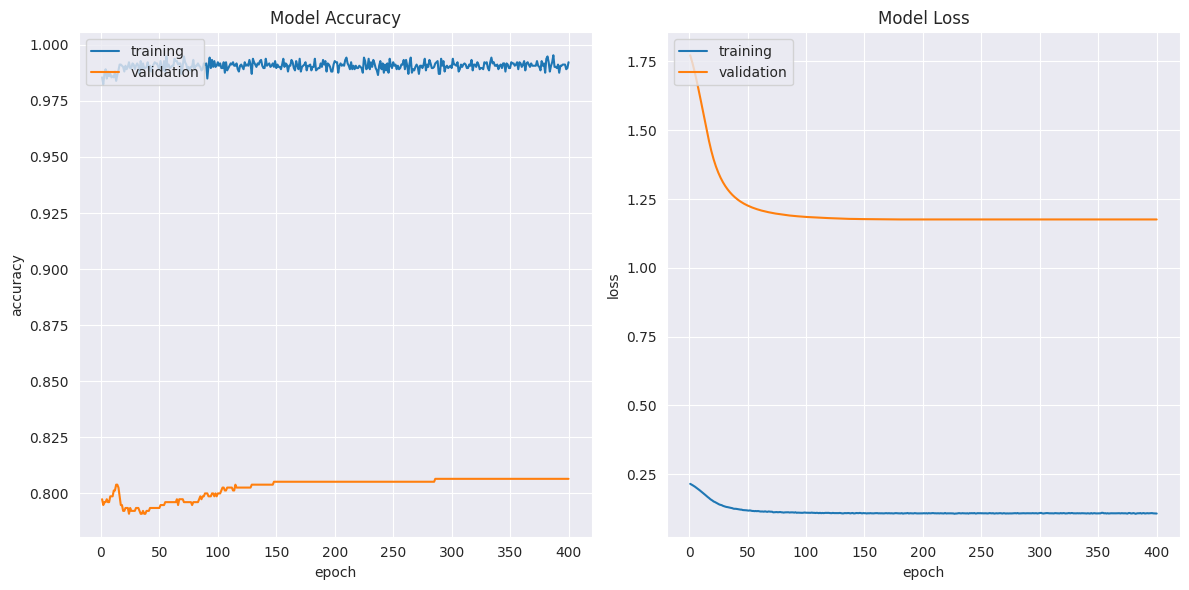

In [15]:
import matplotlib.pyplot as plt


def plot_and_save_combined_history(hist, checkpoint_dir):
    acc = hist.history["accuracy"]
    val_acc = hist.history["val_accuracy"]
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    print(f'Max Training accuracy: {max(acc)}')
    print(
        f'val_loss: {min(val_loss)} in epoch {val_loss.index(min(val_loss))}, val_accuracy: {max(val_acc)} in epoch {val_acc.index(max(val_acc))}')

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="training")
    plt.plot(epochs, val_acc, label="validation")
    plt.title("Model Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="training")
    plt.plot(epochs, val_loss, label="validation")
    plt.title("Model Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    plt.tight_layout()

    plt.savefig(str(checkpoint_dir / 'training_history.png'))

    plt.show()


plot_and_save_combined_history(history, checkpoint_dir)

In [16]:
from tensorflow.keras.models import load_model

best_checkpoint_by_loss = str(checkpoint_dir / "best_model_by_loss.keras")
best_checkpoint_by_acc = str(checkpoint_dir / "best_model.keras")
best_model_by_loss = load_model(best_checkpoint_by_loss, safe_mode=False)
best_model_by_acc = load_model(best_checkpoint_by_acc, safe_mode=False)

In [17]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors_val = best_model_by_acc.predict(val_dataset)
y_pred_val = np.argmax(y_pred_vectors_val, axis=1)
y_true_val = np.concatenate([y for _, y in val_dataset], axis=0)

report = classification_report(y_true_val, y_pred_val, target_names=id_to_emotion.values(), digits=4)
print(report)

25/25 [==============================] - 5s 184ms/step
              precision    recall  f1-score   support

     Neutral     0.7941    0.9818    0.8780       110
       Happy     0.8134    0.9909    0.8934       110
         Sad     0.7967    0.8909    0.8412       110
    Surprise     0.9107    0.9273    0.9189       110
        Fear     0.8132    0.6727    0.7363       110
     Disgust     0.6832    0.6273    0.6540       110
       Anger     0.8356    0.5545    0.6667       110

    accuracy                         0.8065       770
   macro avg     0.8067    0.8065    0.7984       770
weighted avg     0.8067    0.8065    0.7984       770



[[108   2   0   0   0   0   0]
 [  1 109   0   0   0   0   0]
 [  6   1  98   0   0   3   2]
 [  0   1   0 102   7   0   0]
 [  8  10   0   8  74  10   0]
 [  3   5  11   2  10  69  10]
 [ 10   6  14   0   0  19  61]]


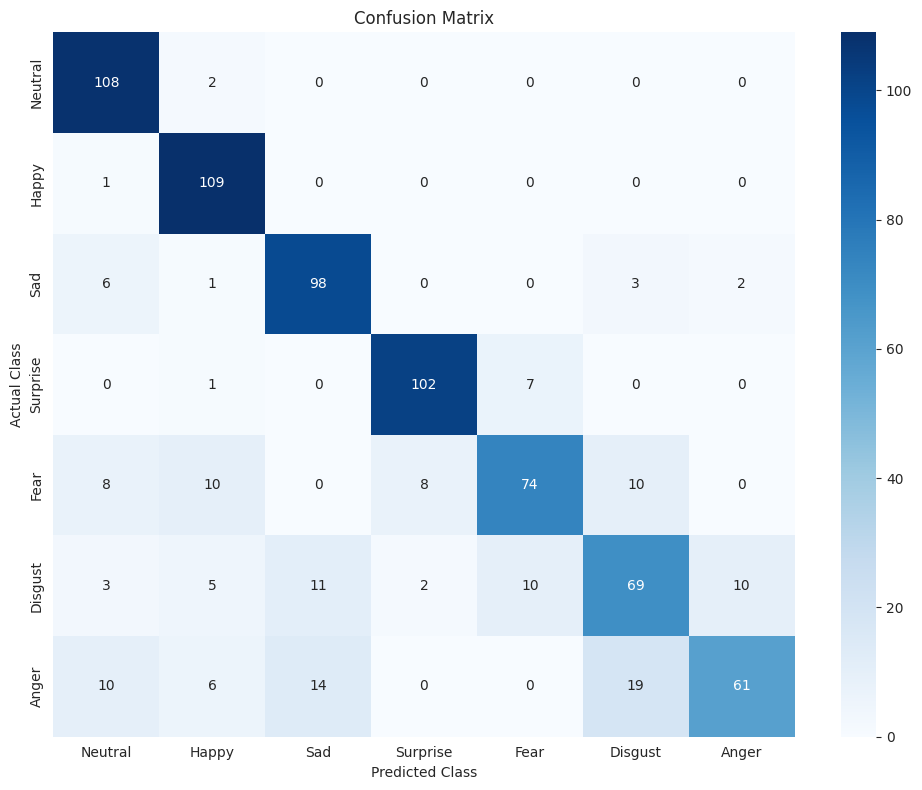

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


val_cm = plot_confusion_matrix(y_true_val, y_pred_val)

## Evaluate Model

In [19]:
test_loss_loss_model, test_acc_loss_model = best_model_by_loss.evaluate(test_dataset)
print(f"Test accuracy of best model by val_loss: {test_acc_loss_model}")

test_loss_acc_model, test_acc_acc_model = best_model_by_acc.evaluate(test_dataset)
print(f"Test accuracy of best model by val_acc: {test_acc_acc_model}")

24/24 [==============================] - 6s 189ms/step - loss: 1.2783 - accuracy: 0.7897
Test accuracy of best model by val_loss: 0.7896825671195984
24/24 [==============================] - 6s 189ms/step - loss: 1.2783 - accuracy: 0.7897
Test accuracy of best model by val_acc: 0.7896825671195984


In [20]:
best_model = best_model_by_acc

In [21]:
y_pred_vectors = best_model.predict(test_dataset)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

24/24 [==============================] - 5s 188ms/step
              precision    recall  f1-score   support

     Neutral     0.8636    0.8796    0.8716       108
       Happy     0.8030    0.9815    0.8833       108
         Sad     0.9390    0.7130    0.8105       108
    Surprise     0.8942    0.8611    0.8774       108
        Fear     0.8119    0.7593    0.7847       108
     Disgust     0.6077    0.7315    0.6639       108
       Anger     0.6701    0.6019    0.6341       108

    accuracy                         0.7897       756
   macro avg     0.7985    0.7897    0.7894       756
weighted avg     0.7985    0.7897    0.7894       756



[[ 95   4   1   0   0   3   5]
 [  0 106   0   0   1   0   1]
 [  8   0  77   0   1   2  20]
 [  0   0   0  93  14   1   0]
 [  2   4   0   9  82  11   0]
 [  0  17   3   2   1  79   6]
 [  5   1   1   0   2  34  65]]


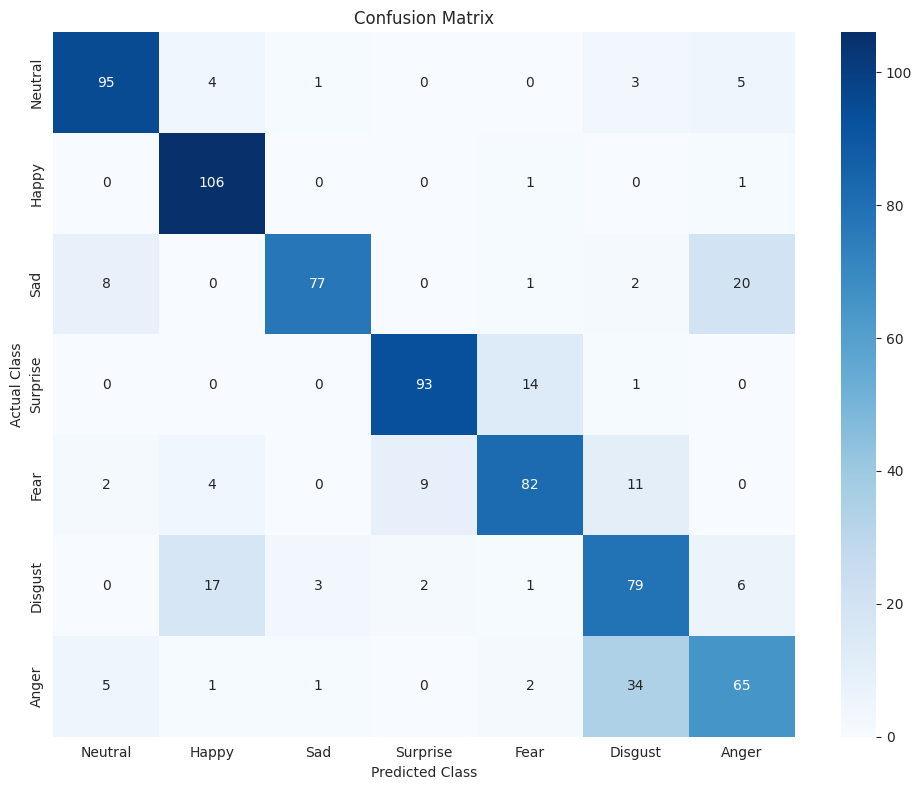

In [22]:
cm_figure = plot_confusion_matrix(y_true, y_pred)

In [23]:
def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, checkpoint_dir)

In [24]:
import time

time.sleep(3)

In [25]:
import shutil

shutil.copy2((Path() / name_of_this_notebook), (checkpoint_dir / name_of_this_notebook))

PosixPath('20240617-1121-checkpoint-batch-32-lr-1e-03-CROSS-ATTENTION/late_fusion_cross_attention.ipynb')